<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#As-SARS-CoV-2-spreads-around-the-world-and-variants-emerge,-there-are-mutations-emerge-that-lead-to-antibody-escape-in-populations-where-there-is-low-seroprevalence.-" data-toc-modified-id="As-SARS-CoV-2-spreads-around-the-world-and-variants-emerge,-there-are-mutations-emerge-that-lead-to-antibody-escape-in-populations-where-there-is-low-seroprevalence.--1"><span class="toc-item-num">1&nbsp;&nbsp;</span>As SARS-CoV-2 spreads around the world and variants emerge, there are mutations emerge that lead to antibody escape in populations where there is low seroprevalence. </a></span></li><li><span><a href="#CoVID19-Model" data-toc-modified-id="CoVID19-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>CoVID19 Model</a></span></li><li><span><a href="#Competition" data-toc-modified-id="Competition-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Competition</a></span><ul class="toc-item"><li><span><a href="#What-if-the-new-strain-arrives-when-the-epidemic-is-already-on-it's-way-so-that-the-original-strain-has-a-head-start?" data-toc-modified-id="What-if-the-new-strain-arrives-when-the-epidemic-is-already-on-it's-way-so-that-the-original-strain-has-a-head-start?-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>What if the new strain arrives when the epidemic is already on it's way so that the original strain has a head start?</a></span></li></ul></li><li><span><a href="#Antibody-Escape" data-toc-modified-id="Antibody-Escape-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Antibody Escape</a></span><ul class="toc-item"><li><span><a href="#What-if-the-new-strain-arrives-when-the-epidemic-is-already-on-it's-way-so-that-the-original-strain-has-a-head-start?" data-toc-modified-id="What-if-the-new-strain-arrives-when-the-epidemic-is-already-on-it's-way-so-that-the-original-strain-has-a-head-start?-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>What if the new strain arrives when the epidemic is already on it's way so that the original strain has a head start?</a></span></li></ul></li><li><span><a href="#Bidirectional-Antibody-escape-and-Co-infection" data-toc-modified-id="Bidirectional-Antibody-escape-and-Co-infection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bidirectional Antibody escape and Co-infection</a></span><ul class="toc-item"><li><span><a href="#What-if-the-new-strain-arrives-when-the-epidemic-is-already-on-it's-way-so-that-the-original-strain-has-a-head-start?" data-toc-modified-id="What-if-the-new-strain-arrives-when-the-epidemic-is-already-on-it's-way-so-that-the-original-strain-has-a-head-start?-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>What if the new strain arrives when the epidemic is already on it's way so that the original strain has a head start?</a></span></li></ul></li></ul></div>

<h1>Question 3</h1>
<h2>As SARS-CoV-2 spreads around the world and variants emerge, there are mutations emerge that lead to antibody escape in populations where there is low seroprevalence. </h2>
        </div>
</div>

In [3]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

from EpiModel import *

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 6809af2fe13634666b531b60015f62e533961af3

networkx  : 2.5
pandas    : 1.1.3
json      : 2.0.9
scipy     : 1.5.2
cartopy   : 0.17.0
matplotlib: 3.3.2
numpy     : 1.19.2
watermark : 2.1.0



Load default figure style

In [53]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## CoVID19 Model

We start by reintroducing the SEIIRD model as it contains enough features to be (somewhat) realistic while still being relatively simple to understand



In [34]:
mu = 0.1
pD = 0.10
rbeta = 0.75
pa = 0.4
epsilon = 0.4
R0 = 2.0

beta = R0*mu/(pa*rbeta+(1-pa))

SEIRD = EpiModel()
SEIRD.add_interaction('S', 'Eo', 'Io', beta)
SEIRD.add_spontaneous('Eo', 'Io', epsilon*(1-pa))
SEIRD.add_spontaneous('Io', 'Ro', (1-pD)*mu)
SEIRD.add_spontaneous('Io', 'D', pD*mu)

The model contains 7 different transitions across 6 compartments:

In [35]:
print(SEIRD)

Epidemic Model with 5 compartments and 4 transitions:

S + Io = Eo 0.222222
Eo -> Io 0.240000
Io -> Ro 0.090000
Io -> D 0.010000

R0=2.22


Define our initial population

In [36]:
N = 100000
I0 = 10

And integrate the model. This will be our baseline model. For the sake of simplicity we don't worry about seasonal effects as those would affect both strains equally

In [37]:
SEIRD.integrate(365, S=N-I0, Io=I0, Eo=0, Ro=0, D=0)
original = SEIRD.values_.copy()

Now we compute the timeline of the new strain with a value of $R_0$ higher by 0.7

In [78]:
mu = 0.1
pD = 0.10
rbeta = 0.75
pa = 0.4
epsilon = 0.4
R0 = 2.7

beta = R0*mu/(pa*rbeta+(1-pa))

SEIIRD2 = EpiModel()
SEIIRD2.add_interaction('S', 'E', 'Ia', rbeta*beta)
SEIIRD2.add_interaction('S', 'E', 'Is', beta)
SEIIRD2.add_spontaneous('E', 'Ia', epsilon*pa)
SEIIRD2.add_spontaneous('E', 'Is', epsilon*(1-pa))
SEIIRD2.add_spontaneous('Ia', 'R', mu)
SEIIRD2.add_spontaneous('Is', 'R', (1-pD)*mu)
SEIIRD2.add_spontaneous('Is', 'D', pD*mu)

In [79]:
SEIIRD2.integrate(365, S=N-I0, Ia=0, Is=I0, E=0, R=0, D=0)
UK = SEIIRD2.values_.copy()

When we plot them side by side, the difference is clear. The higher $R_0$ produces higher peaks that come earlier in the pandemic

Text(0, 0.5, 'Population')

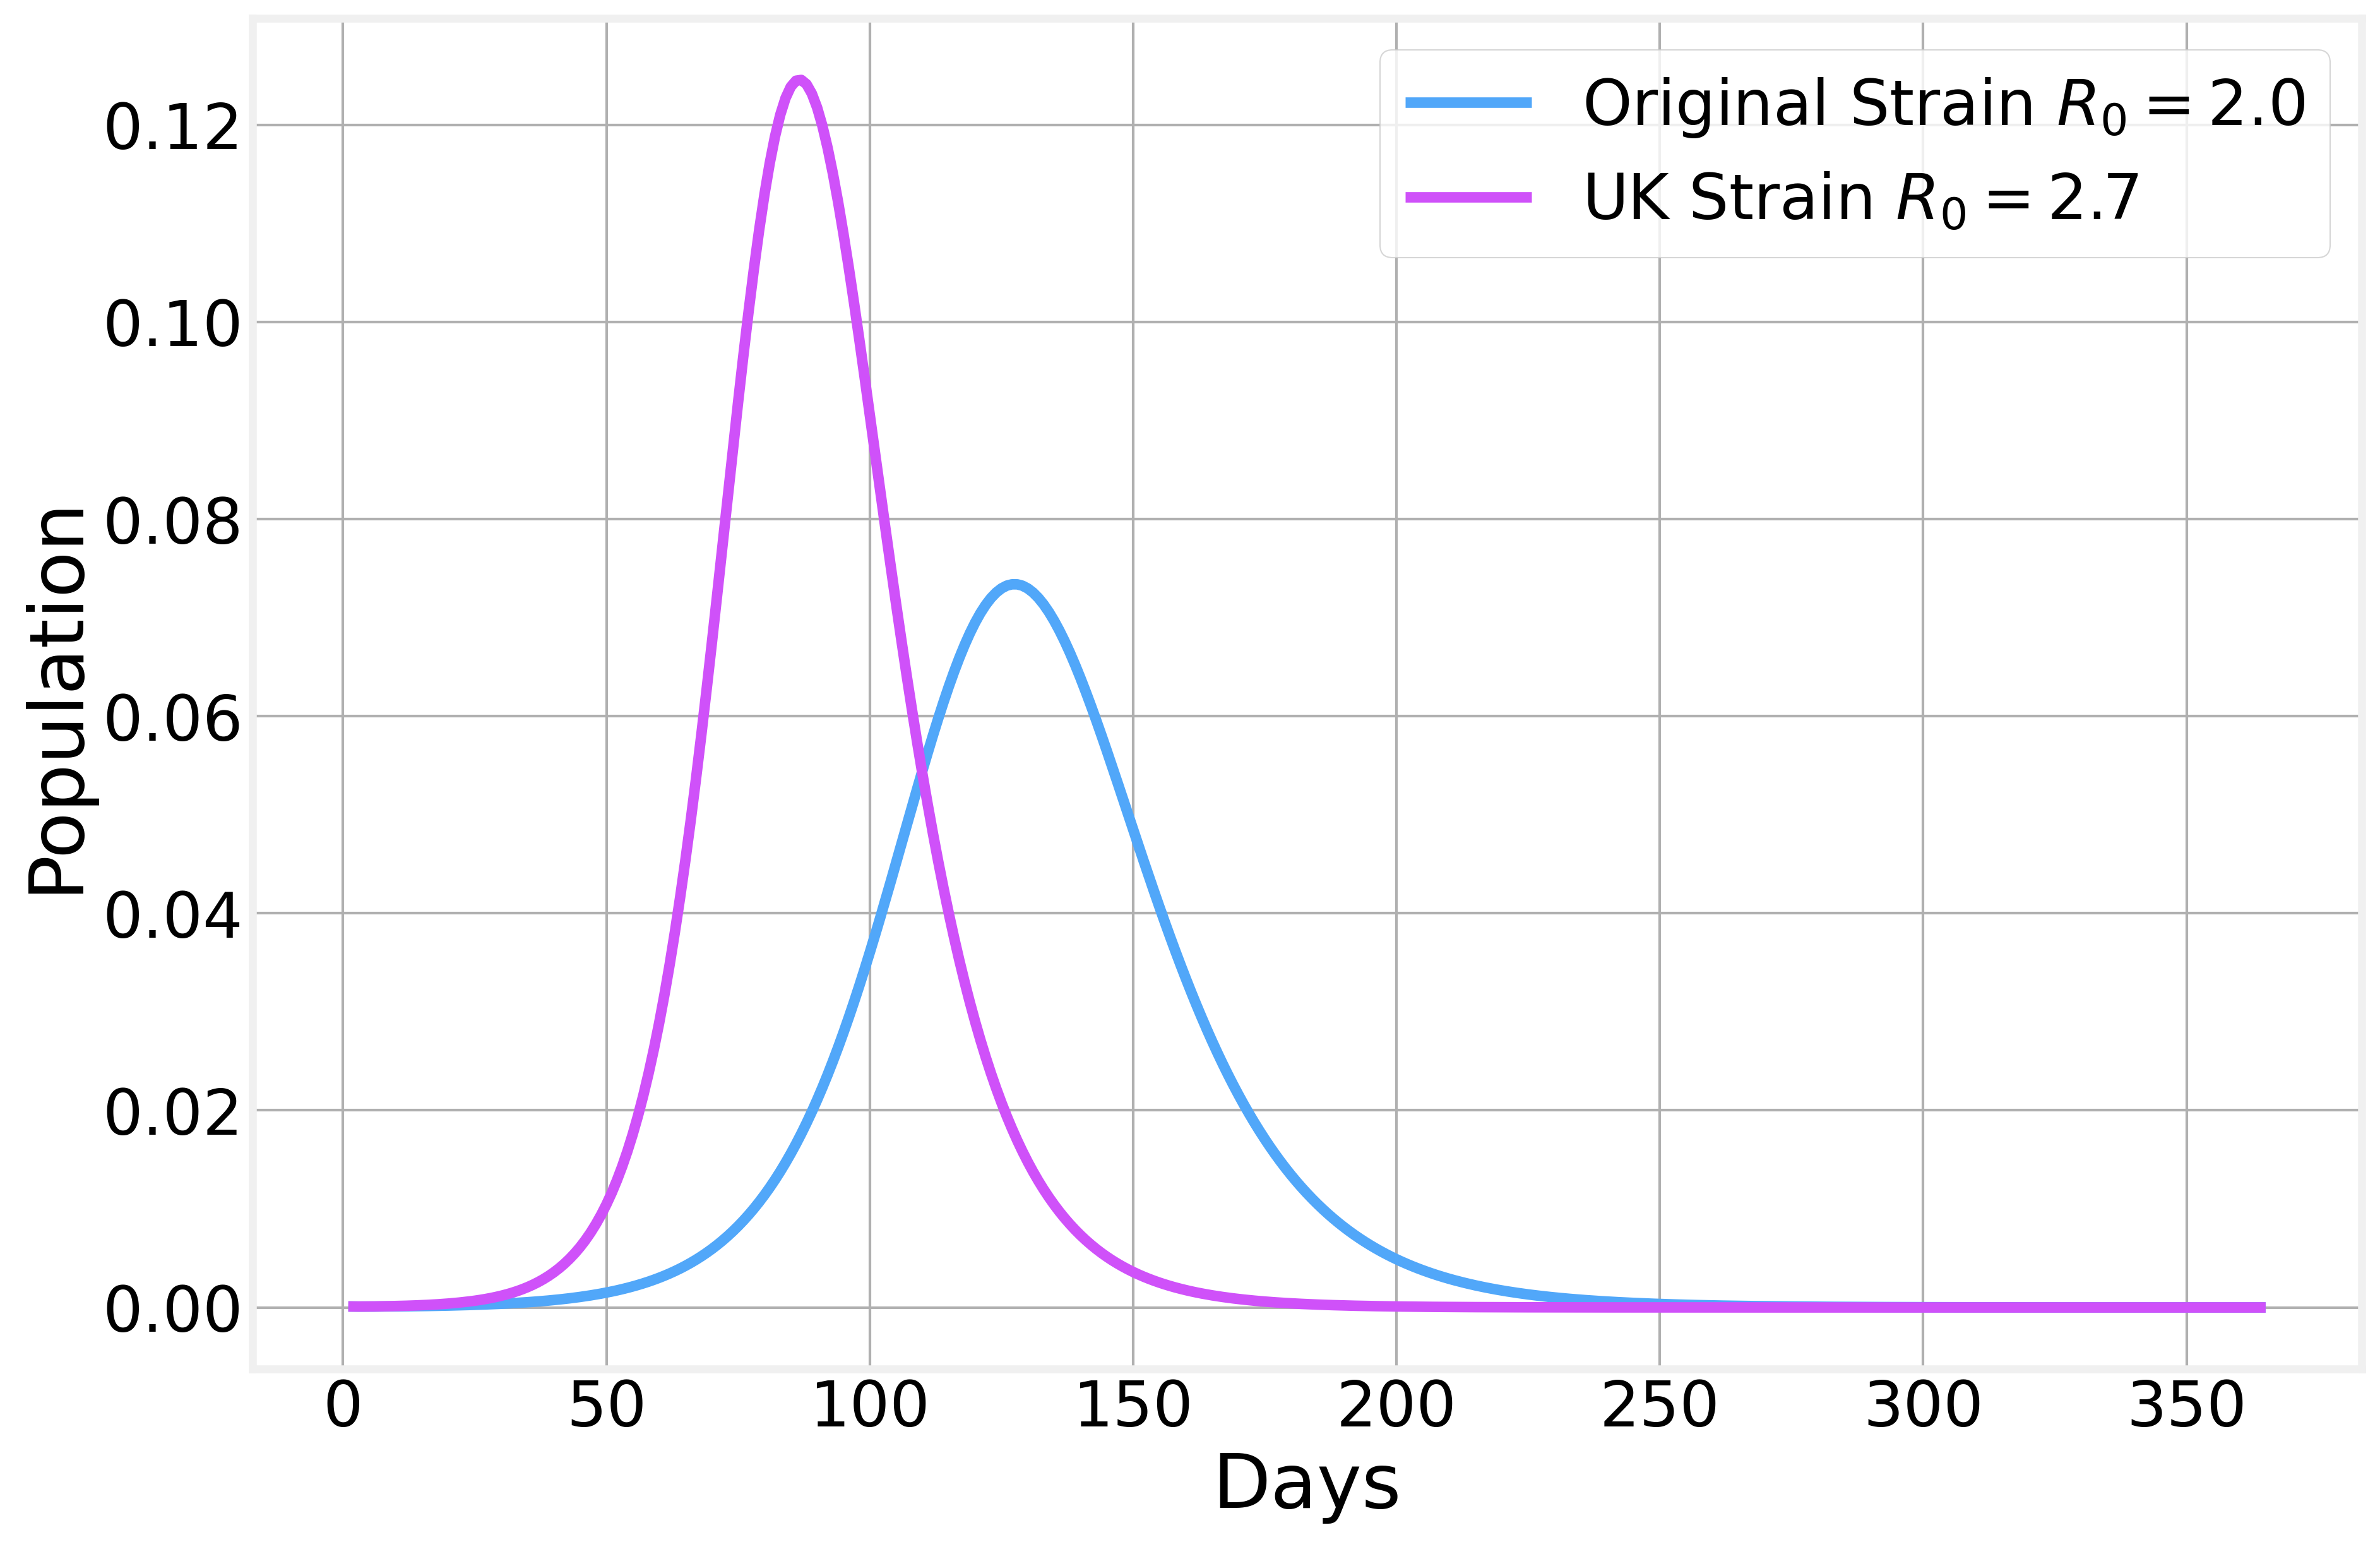

In [80]:
fig, ax = plt.subplots(1)
(original.Is/N).plot(color=colors[0], label='Original Strain $R_0=2.0$', ax=ax)
(UK.Is/N).plot(color=colors[1], label='UK Strain $R_0=2.7$', ax=ax)

ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Population')

## Competition

But what happens if the two strains are spreading on the same population? For this we need to modify our model by adding parallel compartments for both strains

In [13]:
mu = 0.1
pD = 0.10
rbeta = 0.75
pa = 0.4
epsilon = 0.4
R0 = 2.0

betao = R0*mu/(pa*rbeta+(1-pa))
betan = (R0+0.7)*mu/(pa*rbeta+(1-pa))

SEIIRDStrain = EpiModel()
SEIIRDStrain.add_interaction('S', 'Eo', 'Iao', rbeta*betao)
SEIIRDStrain.add_interaction('S', 'Eo', 'Iso', betao)
SEIIRDStrain.add_spontaneous('Eo', 'Iao', epsilon*pa)
SEIIRDStrain.add_spontaneous('Eo', 'Iso', epsilon*(1-pa))
SEIIRDStrain.add_spontaneous('Iao', 'R', mu)
SEIIRDStrain.add_spontaneous('Iso', 'R', (1-pD)*mu)
SEIIRDStrain.add_spontaneous('Iso', 'D', pD*mu)

SEIIRDStrain.add_interaction('S', 'En', 'Ian', rbeta*betan)
SEIIRDStrain.add_interaction('S', 'En', 'Isn', betan)
SEIIRDStrain.add_spontaneous('En', 'Ian', epsilon*pa)
SEIIRDStrain.add_spontaneous('En', 'Isn', epsilon*(1-pa))
SEIIRDStrain.add_spontaneous('Ian', 'R', mu)
SEIIRDStrain.add_spontaneous('Isn', 'R', (1-pD)*mu)
SEIIRDStrain.add_spontaneous('Isn', 'D', pD*mu)

So we now have 9 compartments and 14 transitions.

In [14]:
print(SEIIRDStrain)

Epidemic Model with 9 compartments and 14 transitions:

S + Iao = Eo 0.166667
S + Iso = Eo 0.222222
S + Ian = En 0.225000
S + Isn = En 0.300000
Eo -> Iao 0.160000
Eo -> Iso 0.240000
Iao -> R 0.100000
Iso -> R 0.090000
Iso -> D 0.010000
En -> Ian 0.160000
En -> Isn 0.240000
Ian -> R 0.100000
Isn -> R 0.090000
Isn -> D 0.010000

R0=2.70


And integrating

In [81]:
N = 100000
I0o = 10
I0n = 10

In [82]:
SEIIRDStrain.integrate(365, S=N-I0o-I0n, Iao=0, Iso=I0o, Eo=0, R=0, D=0, Ian=0, Isn=I0n, En=0)
compete = SEIIRDStrain.values_.copy()

We find that the strain with the higher $R_0$ "chokes out" the original strain by reducing the pool of susceptibles 

Text(0.5, 1.0, 'Competing Strains')

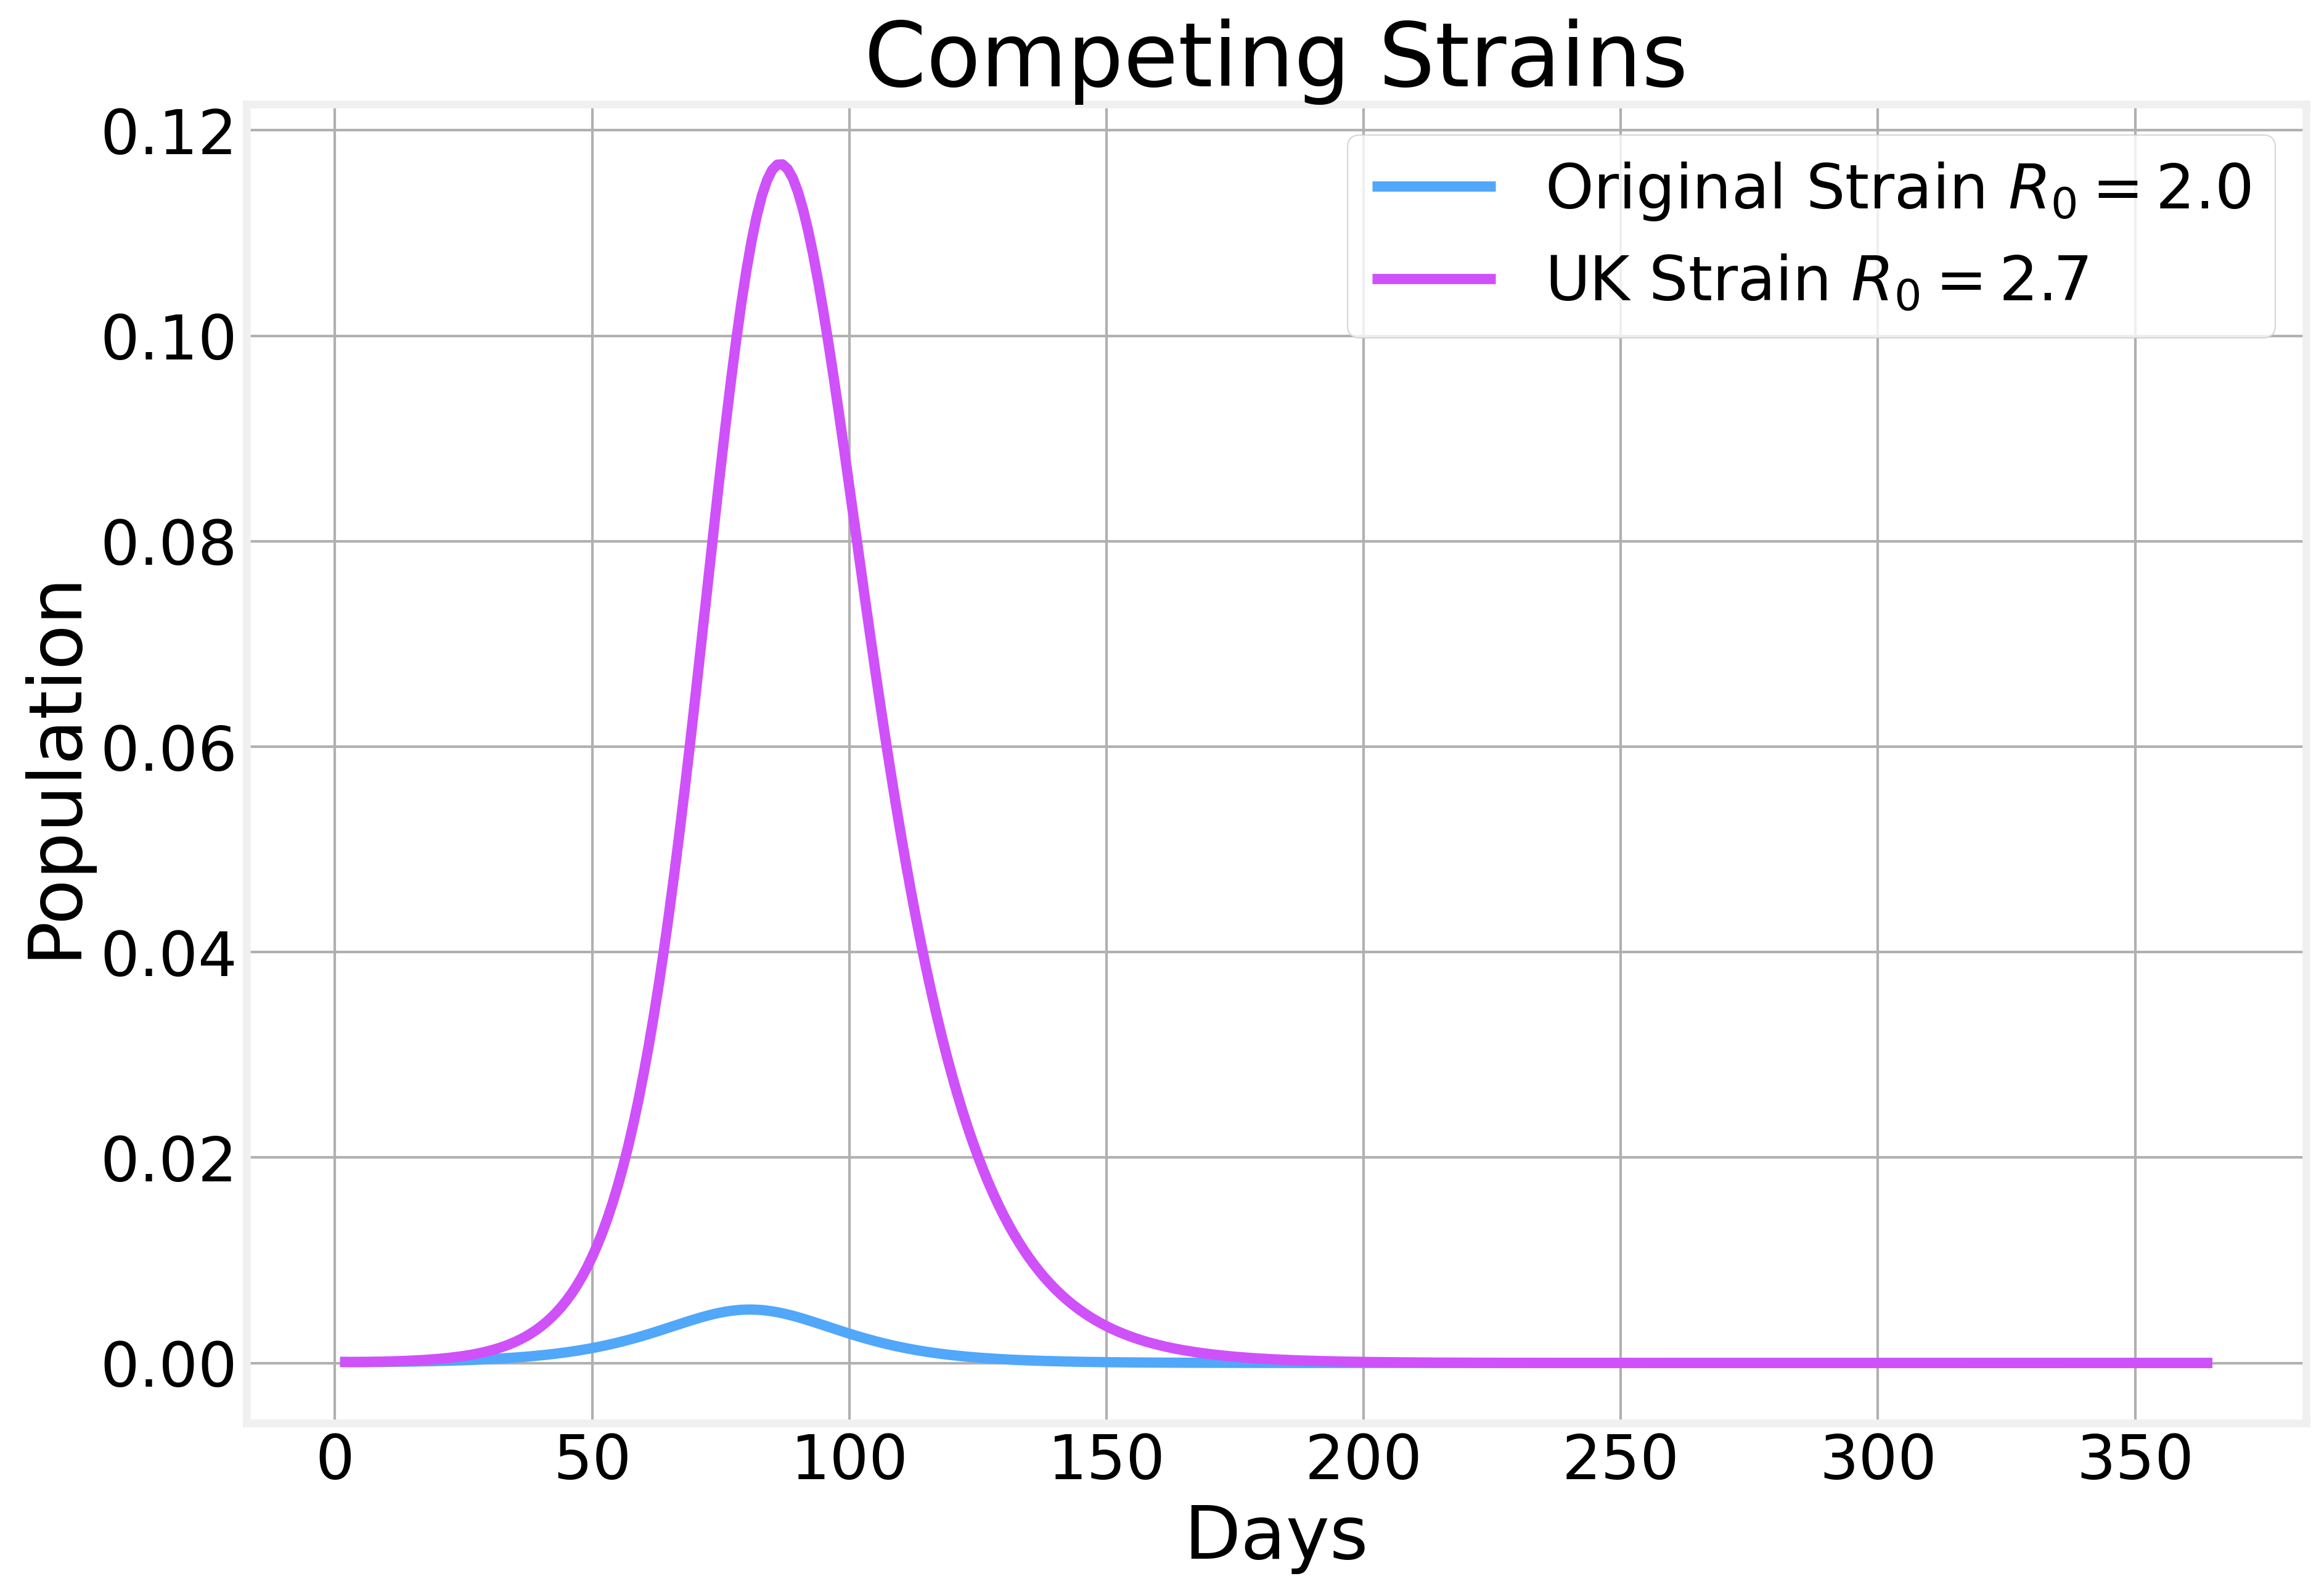

In [83]:
ax = (compete.Iso/N).plot(label='Original Strain $R_0=2.0$')
(compete.Isn/N).plot(ax=ax, label='UK Strain $R_0=2.7$')
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Population')
ax.set_title('Competing Strains')

### What if the new strain arrives when the epidemic is already on it's way so that the original strain has a head start?

In [84]:
[S, Ia, Is, E, R, D] = original.loc[50].values

We initialize our population with the compartments at time 50 from the original epidemic and just add 10 new infectious

In [85]:
SEIIRDStrain.integrate(315, S=S-I0n, Iao=Ia, Iso=Is, Eo=E, R=R, D=D,
                       Ian=0, Isn=I0n, En=0)

In [20]:
introduction = original.iloc[:49].copy()

NameError: name 'original' is not defined

In [87]:
SEIIRDStrain.values_.index += 49

Rename the compartments so that they match

In [88]:
introduction.rename(columns={'Ia':'Iao', 'Is': 'Iso', 'E':'Eo'}, inplace=True)

And combine the two results

In [89]:
introduction = pd.concat([introduction, SEIIRDStrain.values_]).fillna(0)

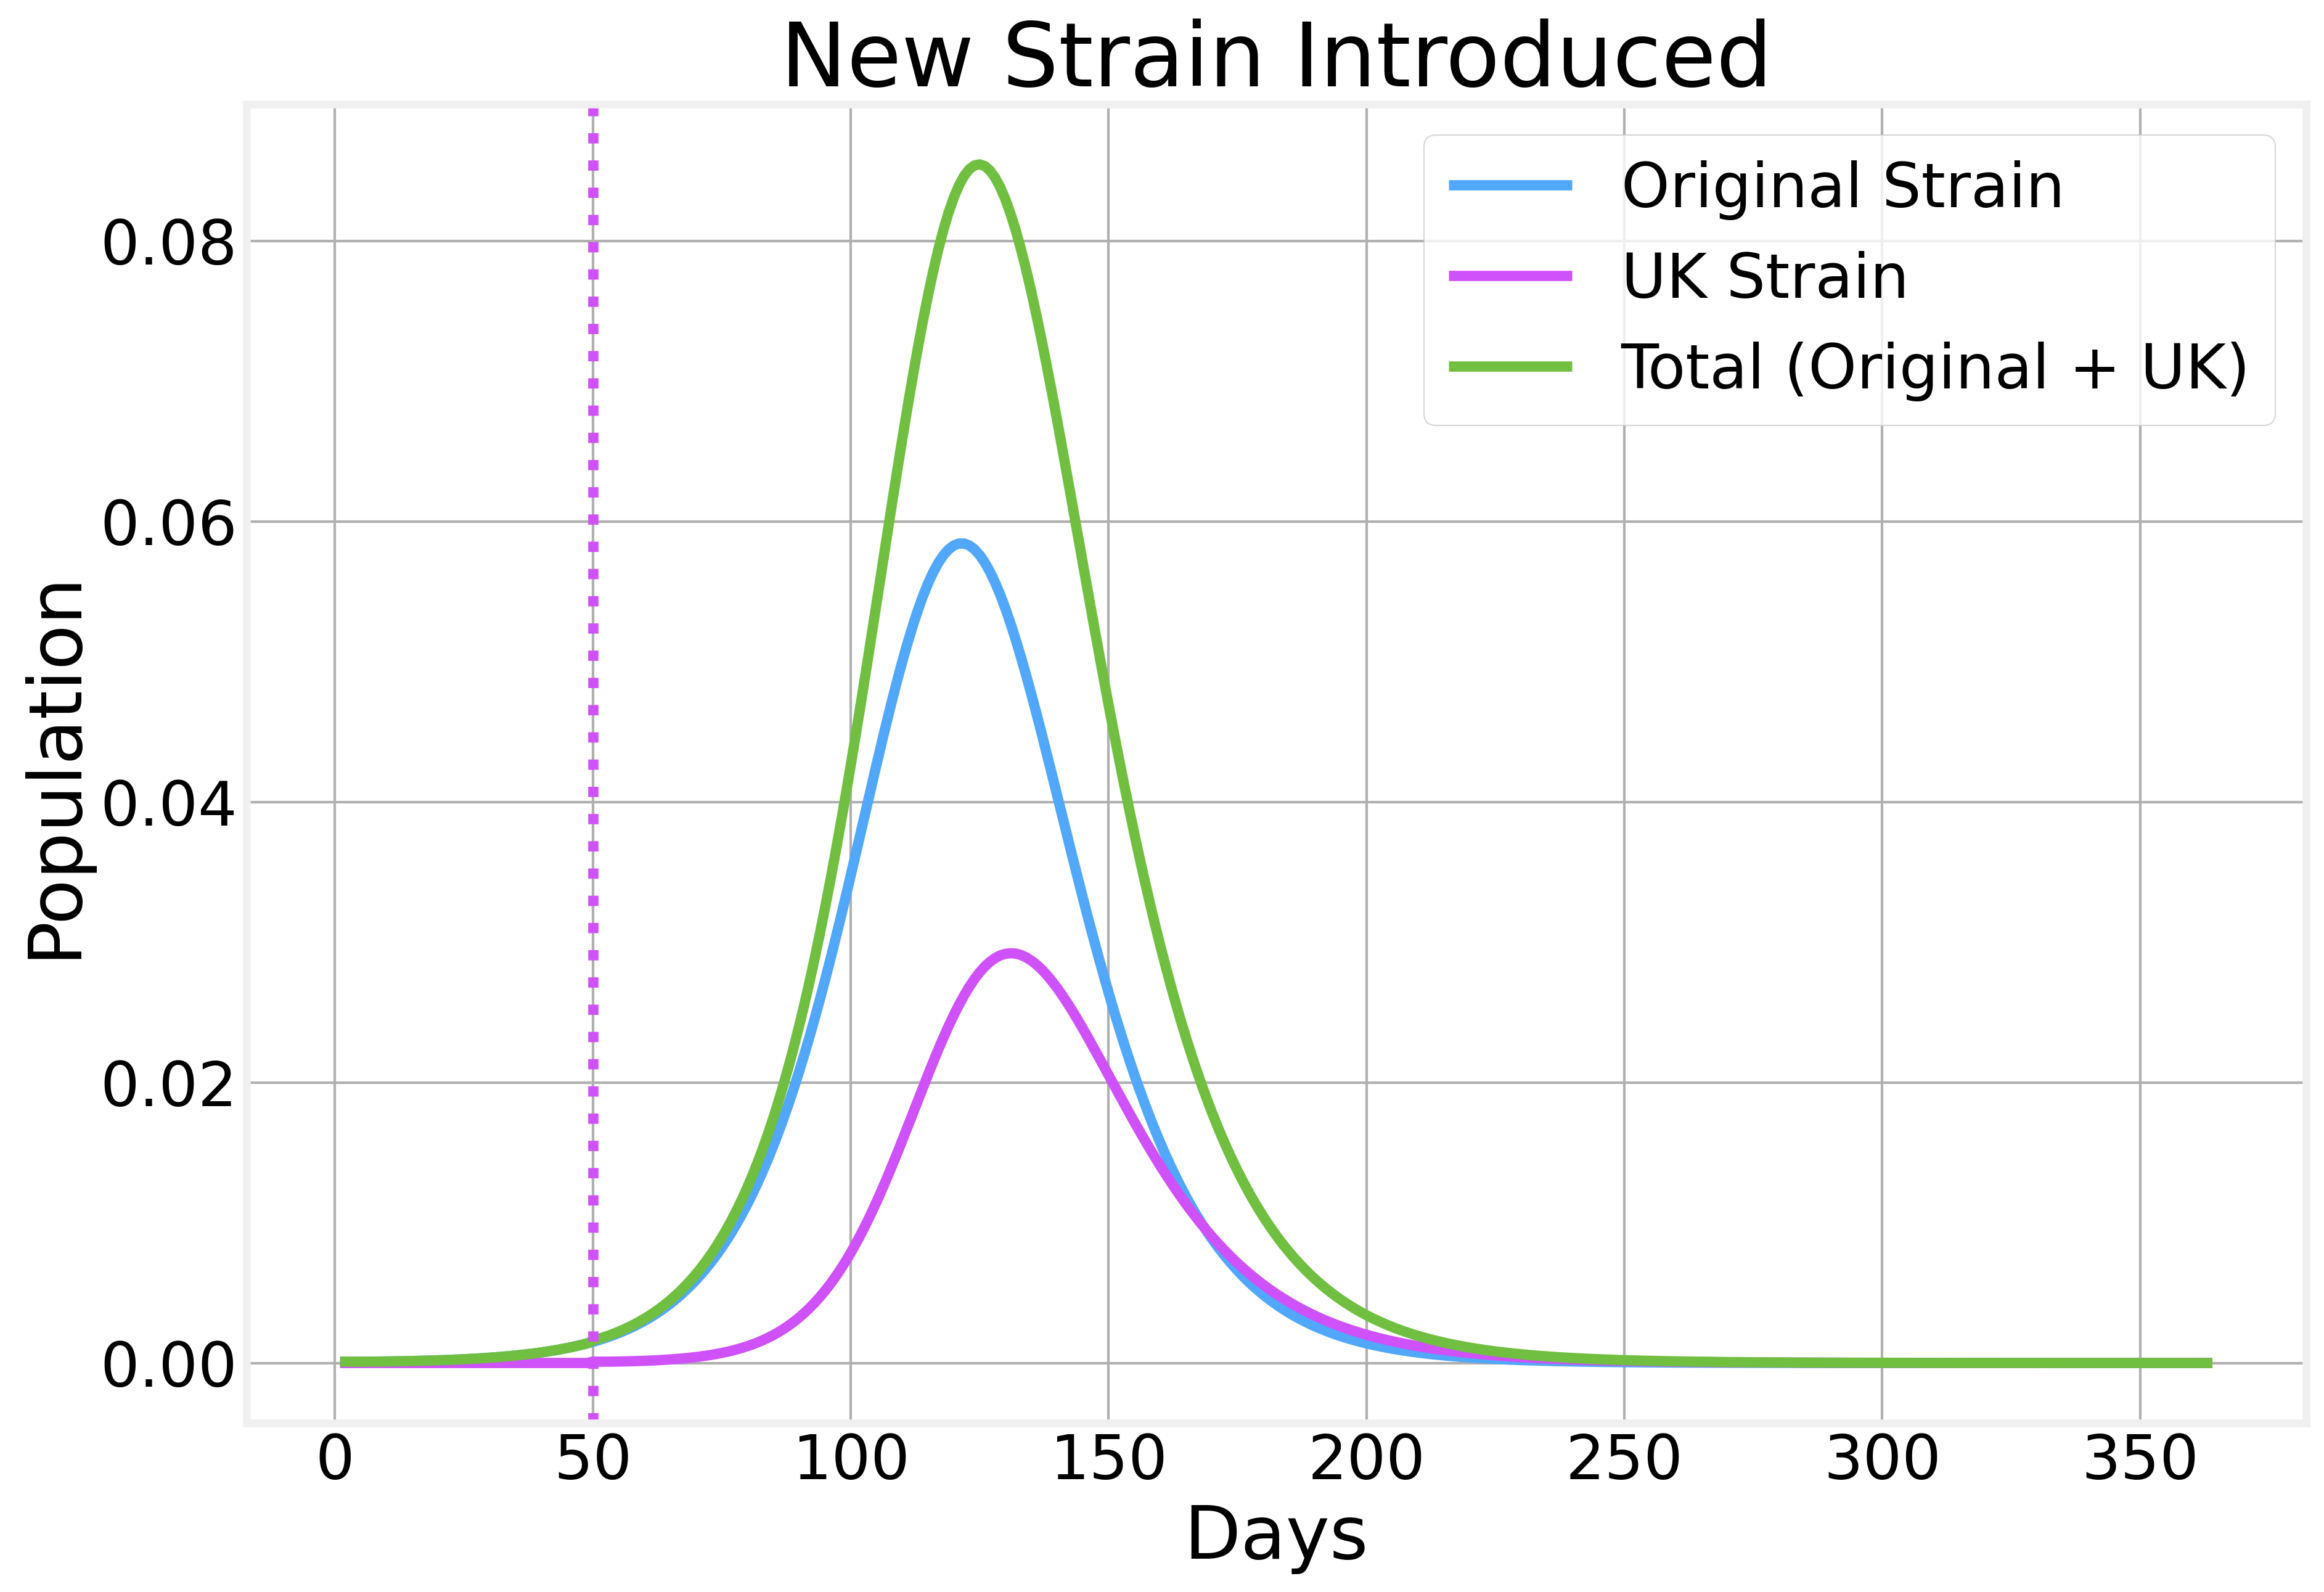

In [90]:
ax = (introduction.Iso/N).plot(label='Original Strain')
((introduction.Isn)/N).plot(ax=ax, label='UK Strain')
((introduction.Iso+introduction.Isn)/N).plot(ax=ax, label='Total (Original + UK)')
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Population')
ax.set_title('New Strain Introduced')
ax.axvline(x=50, linestyle=':', color=colors[1])

## Antibody Escape

What happens if the South African version can infect people who have recovered from the original strain?

In [38]:
mu = 0.1
pD = 0.10
rbeta = 0.75
pa = 0.4
epsilon = 0.4
R0 = 2.0
xi = 0.75

betao = R0*mu/(pa*rbeta+(1-pa))
betan = (R0)*mu/(pa*rbeta+(1-pa))

SEIRDEscape = EpiModel()

SEIRDEscape.add_interaction('S', 'Eo', 'Io', betao)
SEIRDEscape.add_spontaneous('Eo', 'Io', epsilon)
SEIRDEscape.add_spontaneous('Io', 'Ro', (1-pD)*mu)
SEIRDEscape.add_spontaneous('Io', 'D', pD*mu)

SEIRDEscape.add_interaction('S', 'En', 'In', betan)
SEIRDEscape.add_spontaneous('En', 'In', epsilon)

SEIRDEscape.add_spontaneous('In', 'Rn', (1-pD)*mu)
SEIRDEscape.add_spontaneous('In', 'D', pD*mu)

SEIRDEscape.add_interaction('Ro', 'En', 'In', xi)


So we now have 10 compartments and 16 transitions.

In [39]:
print(SEIRDEscape)

Epidemic Model with 8 compartments and 9 transitions:

S + Io = Eo 0.222222
S + In = En 0.222222
Eo -> Io 0.400000
Io -> Ro 0.090000
Io -> D 0.010000
Ro + In = En 0.750000
En -> In 0.400000
In -> Rn 0.090000
In -> D 0.010000

R0=7.50


And integrating

In [40]:
N = 100000
I0o = 10
I0n = 10

In [41]:
SEIRDEscape.integrate(365, S=N-I0o-I0n,  Io=I0o, Eo=0, Ro=0, Rn=0, D=0,  In=I0n, En=0)
compete = SEIRDEscape.values_.copy()

We find that the antibody escape strain dominates the original strain and lasts longer because it can infect people who have recovered from the original strain.

Text(0.5, 1.0, 'Competing Strains with Antibody Escape')

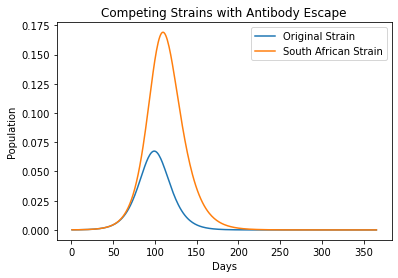

In [42]:
ax = (compete.Io/N).plot(label='Original Strain ')
(compete.In/N).plot(ax=ax, label='South African Strain')
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Population')
ax.set_title('Competing Strains with Antibody Escape')

### What if the new strain arrives when the epidemic is already on it's way so that the original strain has a head start?

In [43]:
[S, Io, Eo, Ro, D] = original.loc[50].values

We initialize our population with the compartments at time 50 from the original epidemic and just add 10 new infectious

In [46]:
SEIRDEscape.integrate(315, S=S-I0n, Io=Io, Eo=Eo, Ro=Ro, D=D, Rn=0,
                       In=I0n, En=0)

In [47]:
introduction = original.iloc[:49].copy()

In [48]:
SEIRDEscape.values_.index += 49

Rename the compartments so that they match

In [49]:
#introduction.rename(columns={'I':'Iao', 'Is': 'Iso', 'E':'Eo', 'R': 'Ro'}, inplace=True)
introduction['Rn'] = 0


And combine the two results

In [50]:
introduction = pd.concat([introduction, SEIRDEscape.values_]).fillna(0)

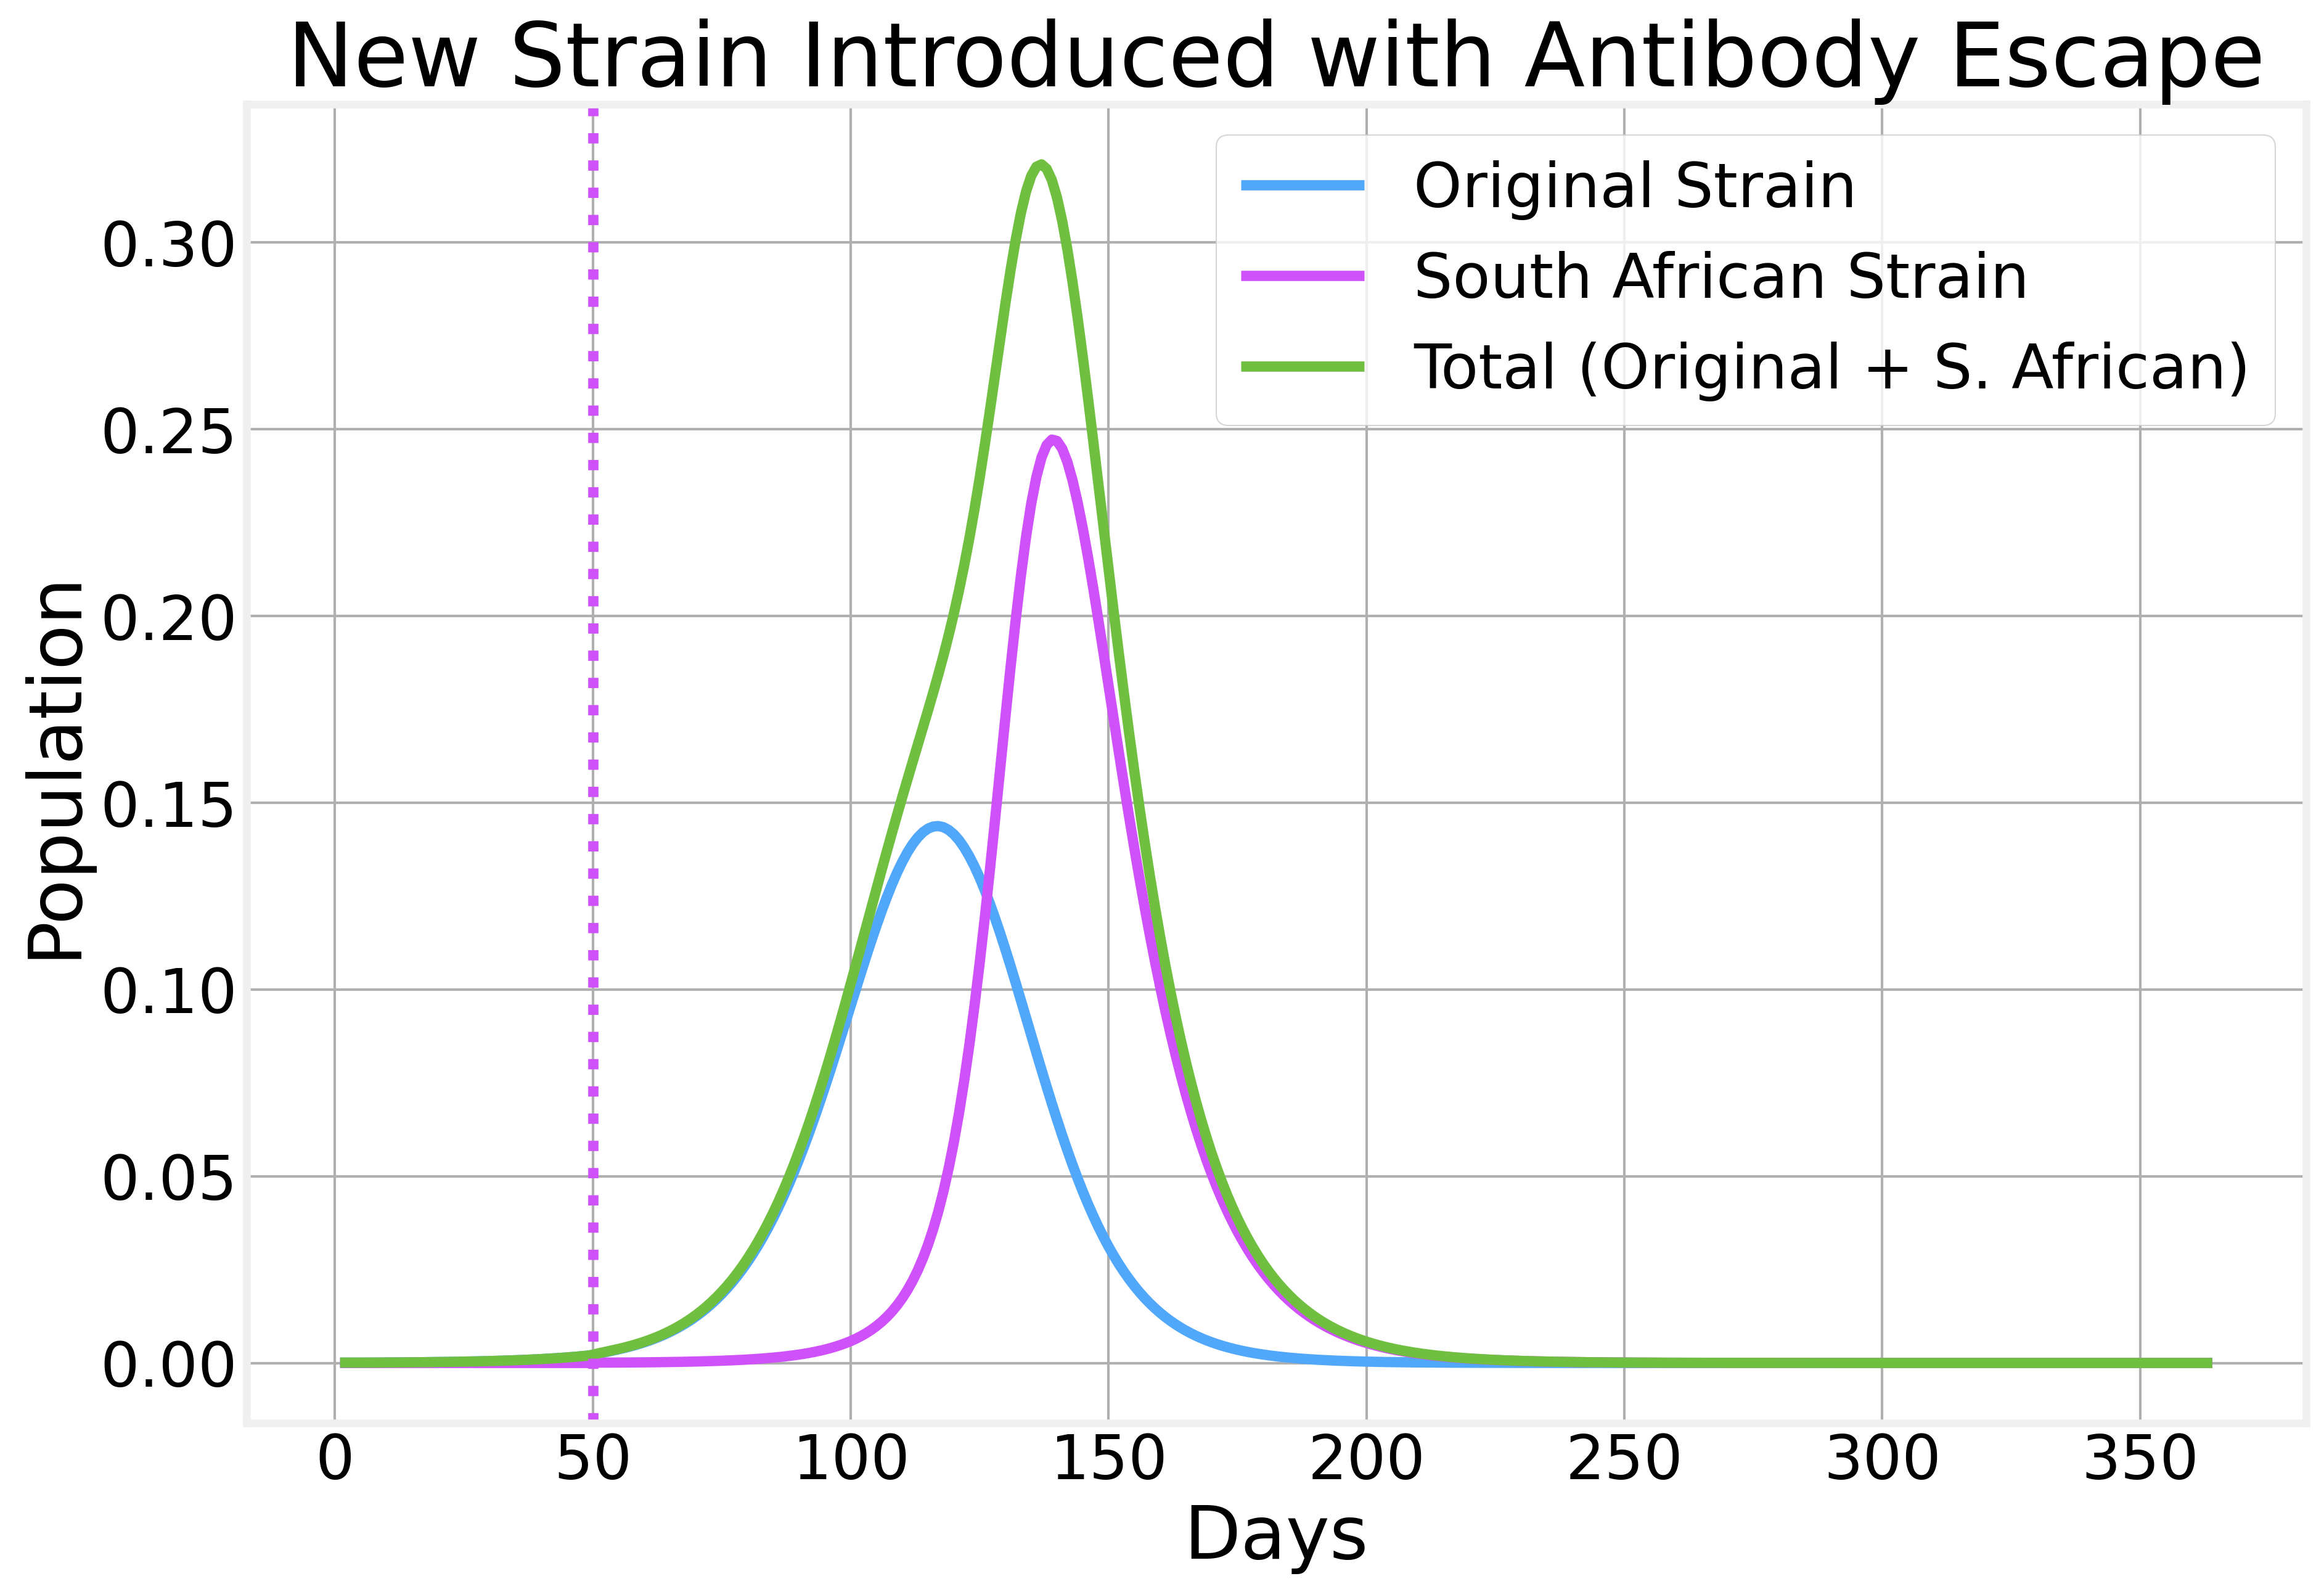

In [54]:
ax = (introduction.Io/N).plot(label='Original Strain')
((introduction.In)/N).plot(ax=ax, label='South African Strain')
((introduction.Io+introduction.In)/N).plot(ax=ax, label='Total (Original + S. African)')
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Population')
ax.set_title('New Strain Introduced with Antibody Escape')
ax.axvline(x=50, linestyle=':', color=colors[1])

# What is the connection between variants, seroconversion and convergent evolution of similar variant gene subsets?

## Bidirectional Antibody escape and Co-infection

But what happens if the two strains can both infect people who have recovered from the other strain?

In [71]:
mu = 0.1
pD = 0.10
rbeta = 0.75
pa = 0.4
epsilon = 0.4
R0 = 2.0
xi = 0.75

betao = R0*mu/(pa*rbeta+(1-pa))
betan = (R0)*mu/(pa*rbeta+(1-pa))

SEIRDEscape2 = EpiModel()
SEIRDEscape2.add_interaction('S', 'Eo', 'Io', betao)
SEIRDEscape2.add_spontaneous('Eo', 'Io', epsilon)
SEIRDEscape2.add_spontaneous('Io', 'Ro', (1-pD)*mu)
SEIRDEscape2.add_spontaneous('Io', 'D', pD*mu)

SEIRDEscape2.add_interaction('S', 'En', 'In', betan)
SEIRDEscape2.add_spontaneous('En', 'In', epsilon)
SEIRDEscape2.add_spontaneous('In', 'Rn', (1-pD)*mu)
SEIRDEscape2.add_spontaneous('In', 'D', pD*mu)

SEIRDEscape2.add_interaction('Ro', 'En', 'In', xi)
SEIRDEscape2.add_interaction('Rn', 'Eo', 'Io', xi)


So we now have 10 compartments and 18 transitions.

In [72]:
print(SEIRDEscape2)

Epidemic Model with 8 compartments and 10 transitions:

S + Io = Eo 0.222222
S + In = En 0.222222
Eo -> Io 0.400000
Io -> Ro 0.090000
Io -> D 0.010000
Ro + In = En 0.750000
En -> In 0.400000
In -> Rn 0.090000
In -> D 0.010000
Rn + Io = Eo 0.750000

R0=7.50


And integrating

In [58]:
N = 100000
I0o = 10
I0n = 10

In [73]:
SEIRDEscape2.integrate(365, S=N-I0o-I0n,  Io=I0o, Eo=0, Ro=0, Rn=0, D=0,  In=I0n, En=0)
compete2 = SEIRDEscape2.values_.copy()

We find the South African strain

Text(0.5, 1.0, 'Competing Strains with Bidirectional Antibody Escape')

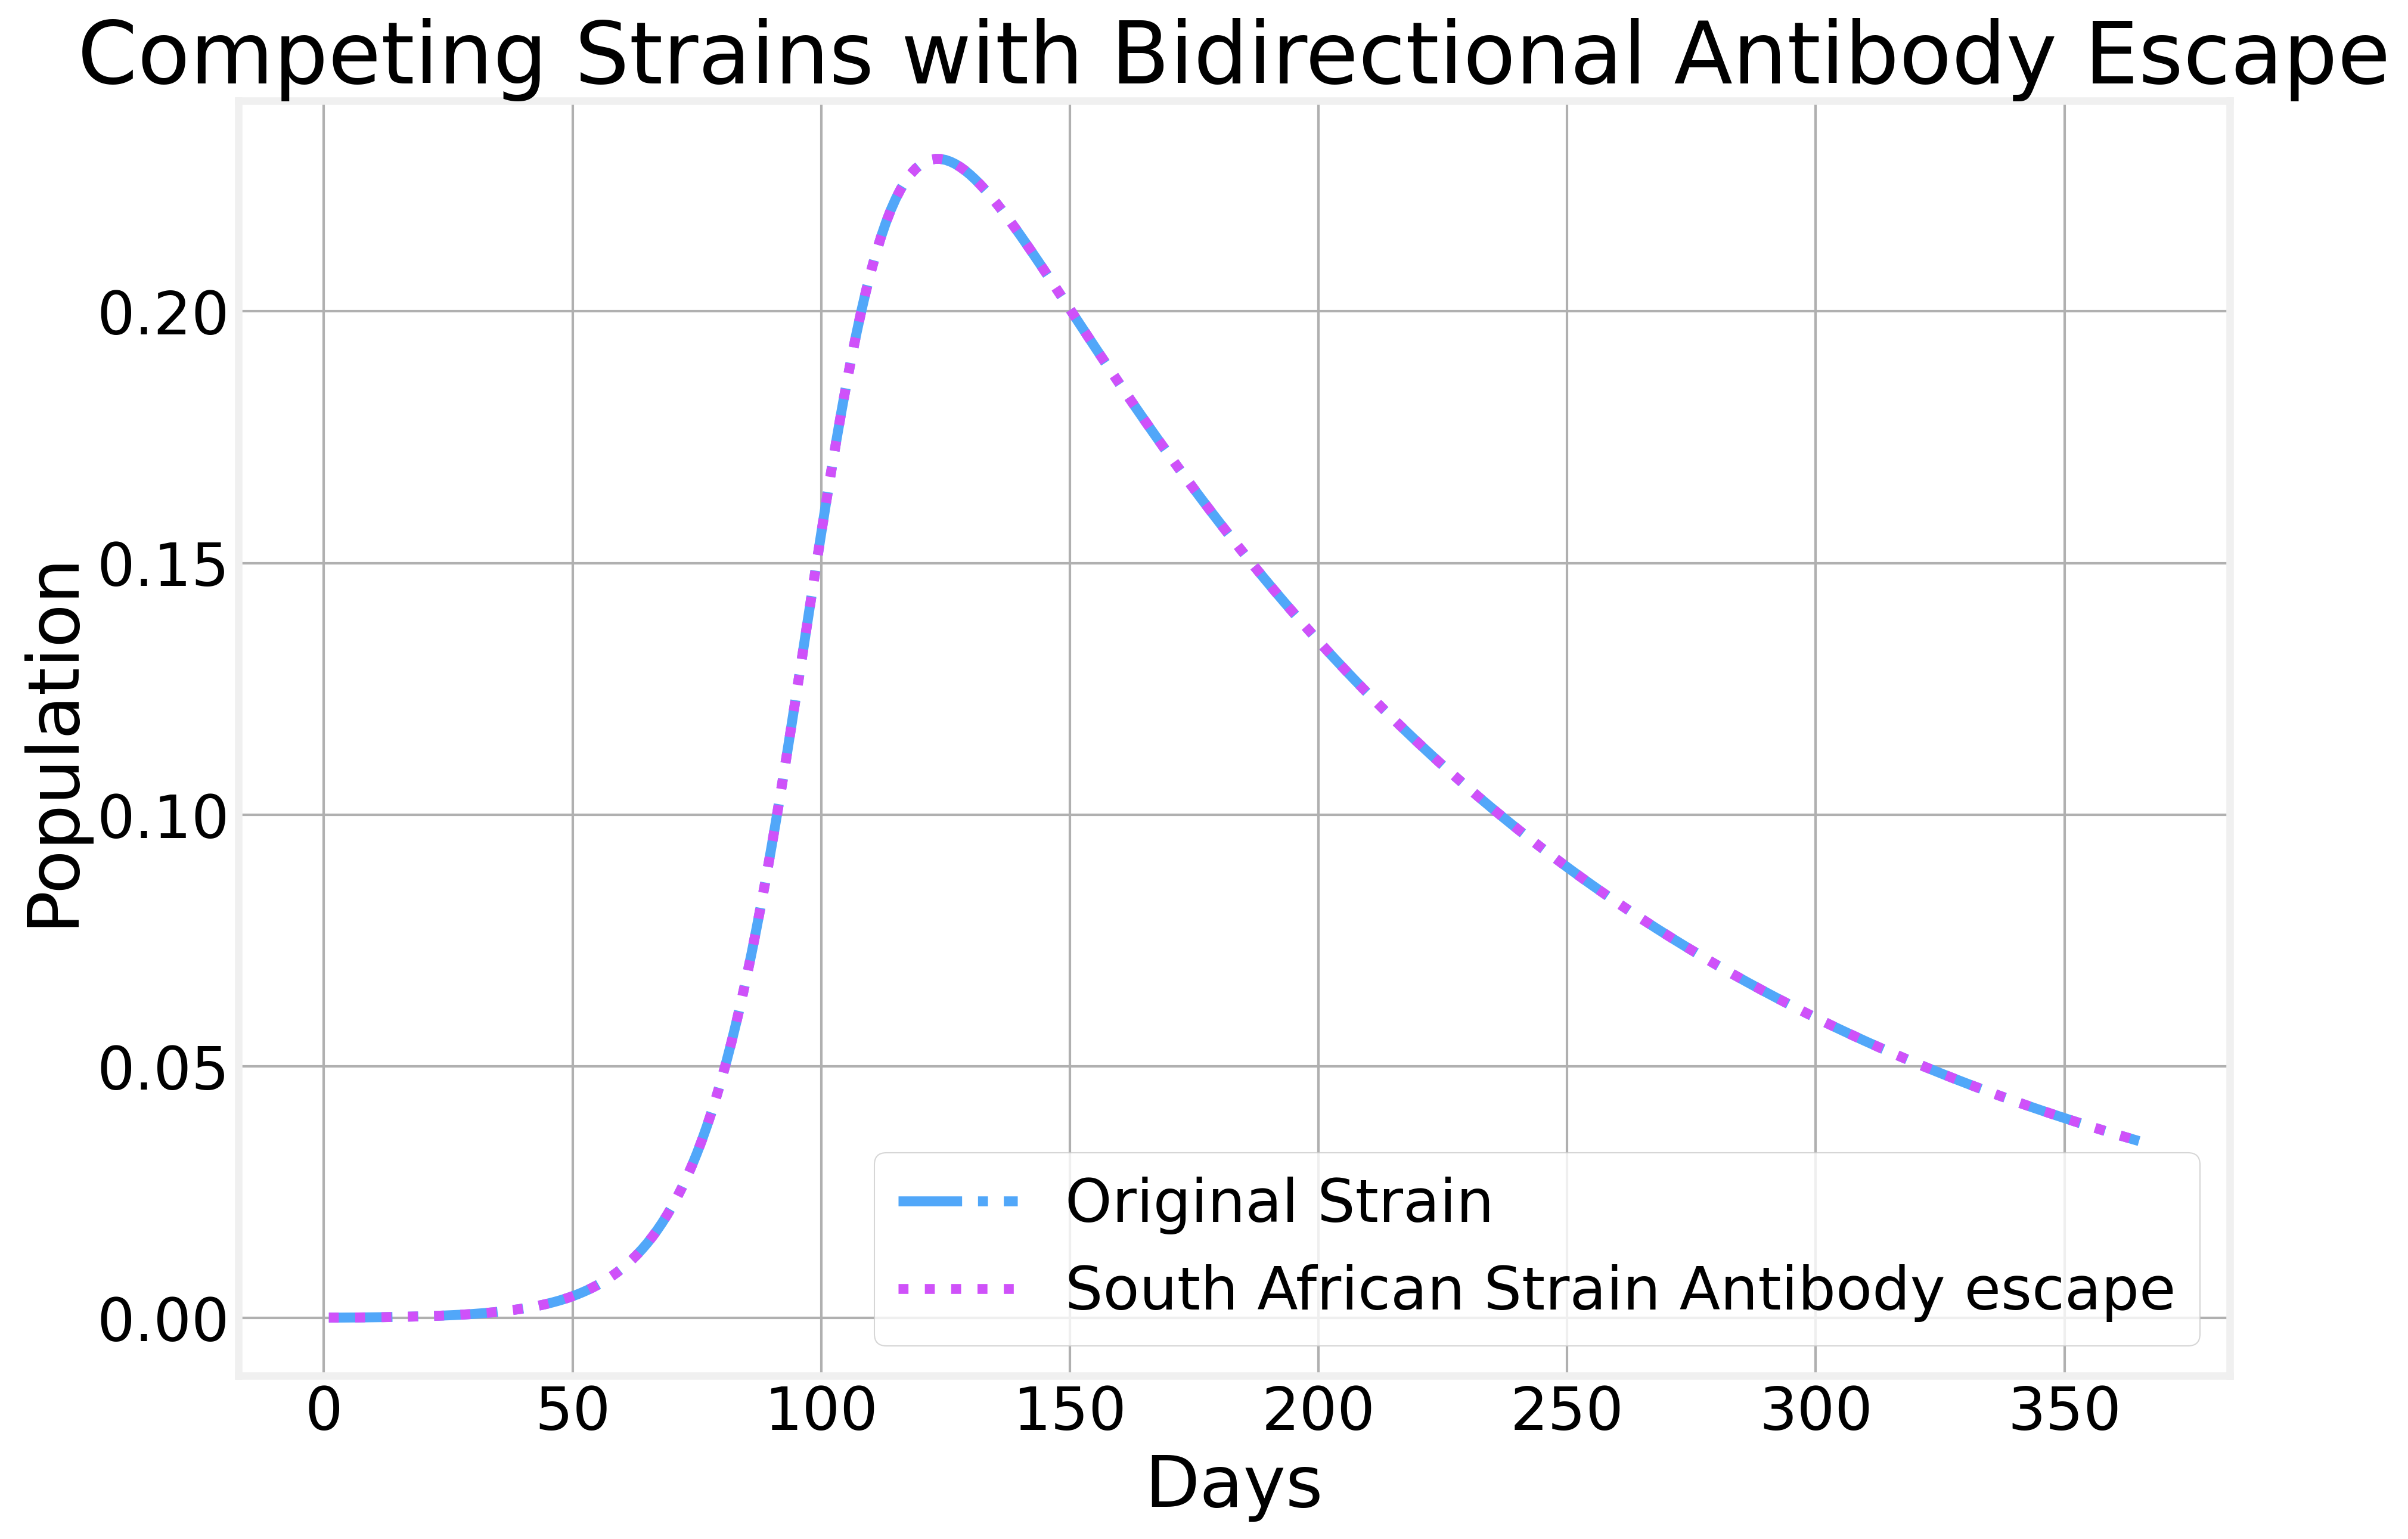

In [75]:
ax = (compete2.Io/N).plot(linestyle='dashdot',label='Original Strain')

(compete2.In/N).plot(ax=ax, linestyle=':', label='South African Strain Antibody escape')
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Population')
ax.set_title('Competing Strains with Bidirectional Antibody Escape')

### What if the new strain arrives when the epidemic is already on it's way so that the original strain has a head start?

In [63]:
[S,  Io, Eo, Ro, D] = original.loc[50].values

We initialize our population with the compartments at time 50 from the original epidemic and just add 10 new infectious

In [64]:
SEIRDEscape2.integrate(315, S=S-I0n,  Io=Io, Eo=Eo, Ro=Ro, D=D, Rn=0,
                        In=I0n, En=0)

In [65]:
introduction2 = original.iloc[:49].copy()

In [67]:
SEIRDEscape2.values_.index += 49

Rename the compartments so that they match

In [68]:
#introduction2.rename(columns={'Ia':'Iao', 'Is': 'Iso', 'E':'Eo', 'R': 'Ro'}, inplace=True)
introduction2['Rn'] = 0


And combine the two results

In [69]:
introduction2 = pd.concat([introduction2, SEIRDEscape2.values_]).fillna(0)

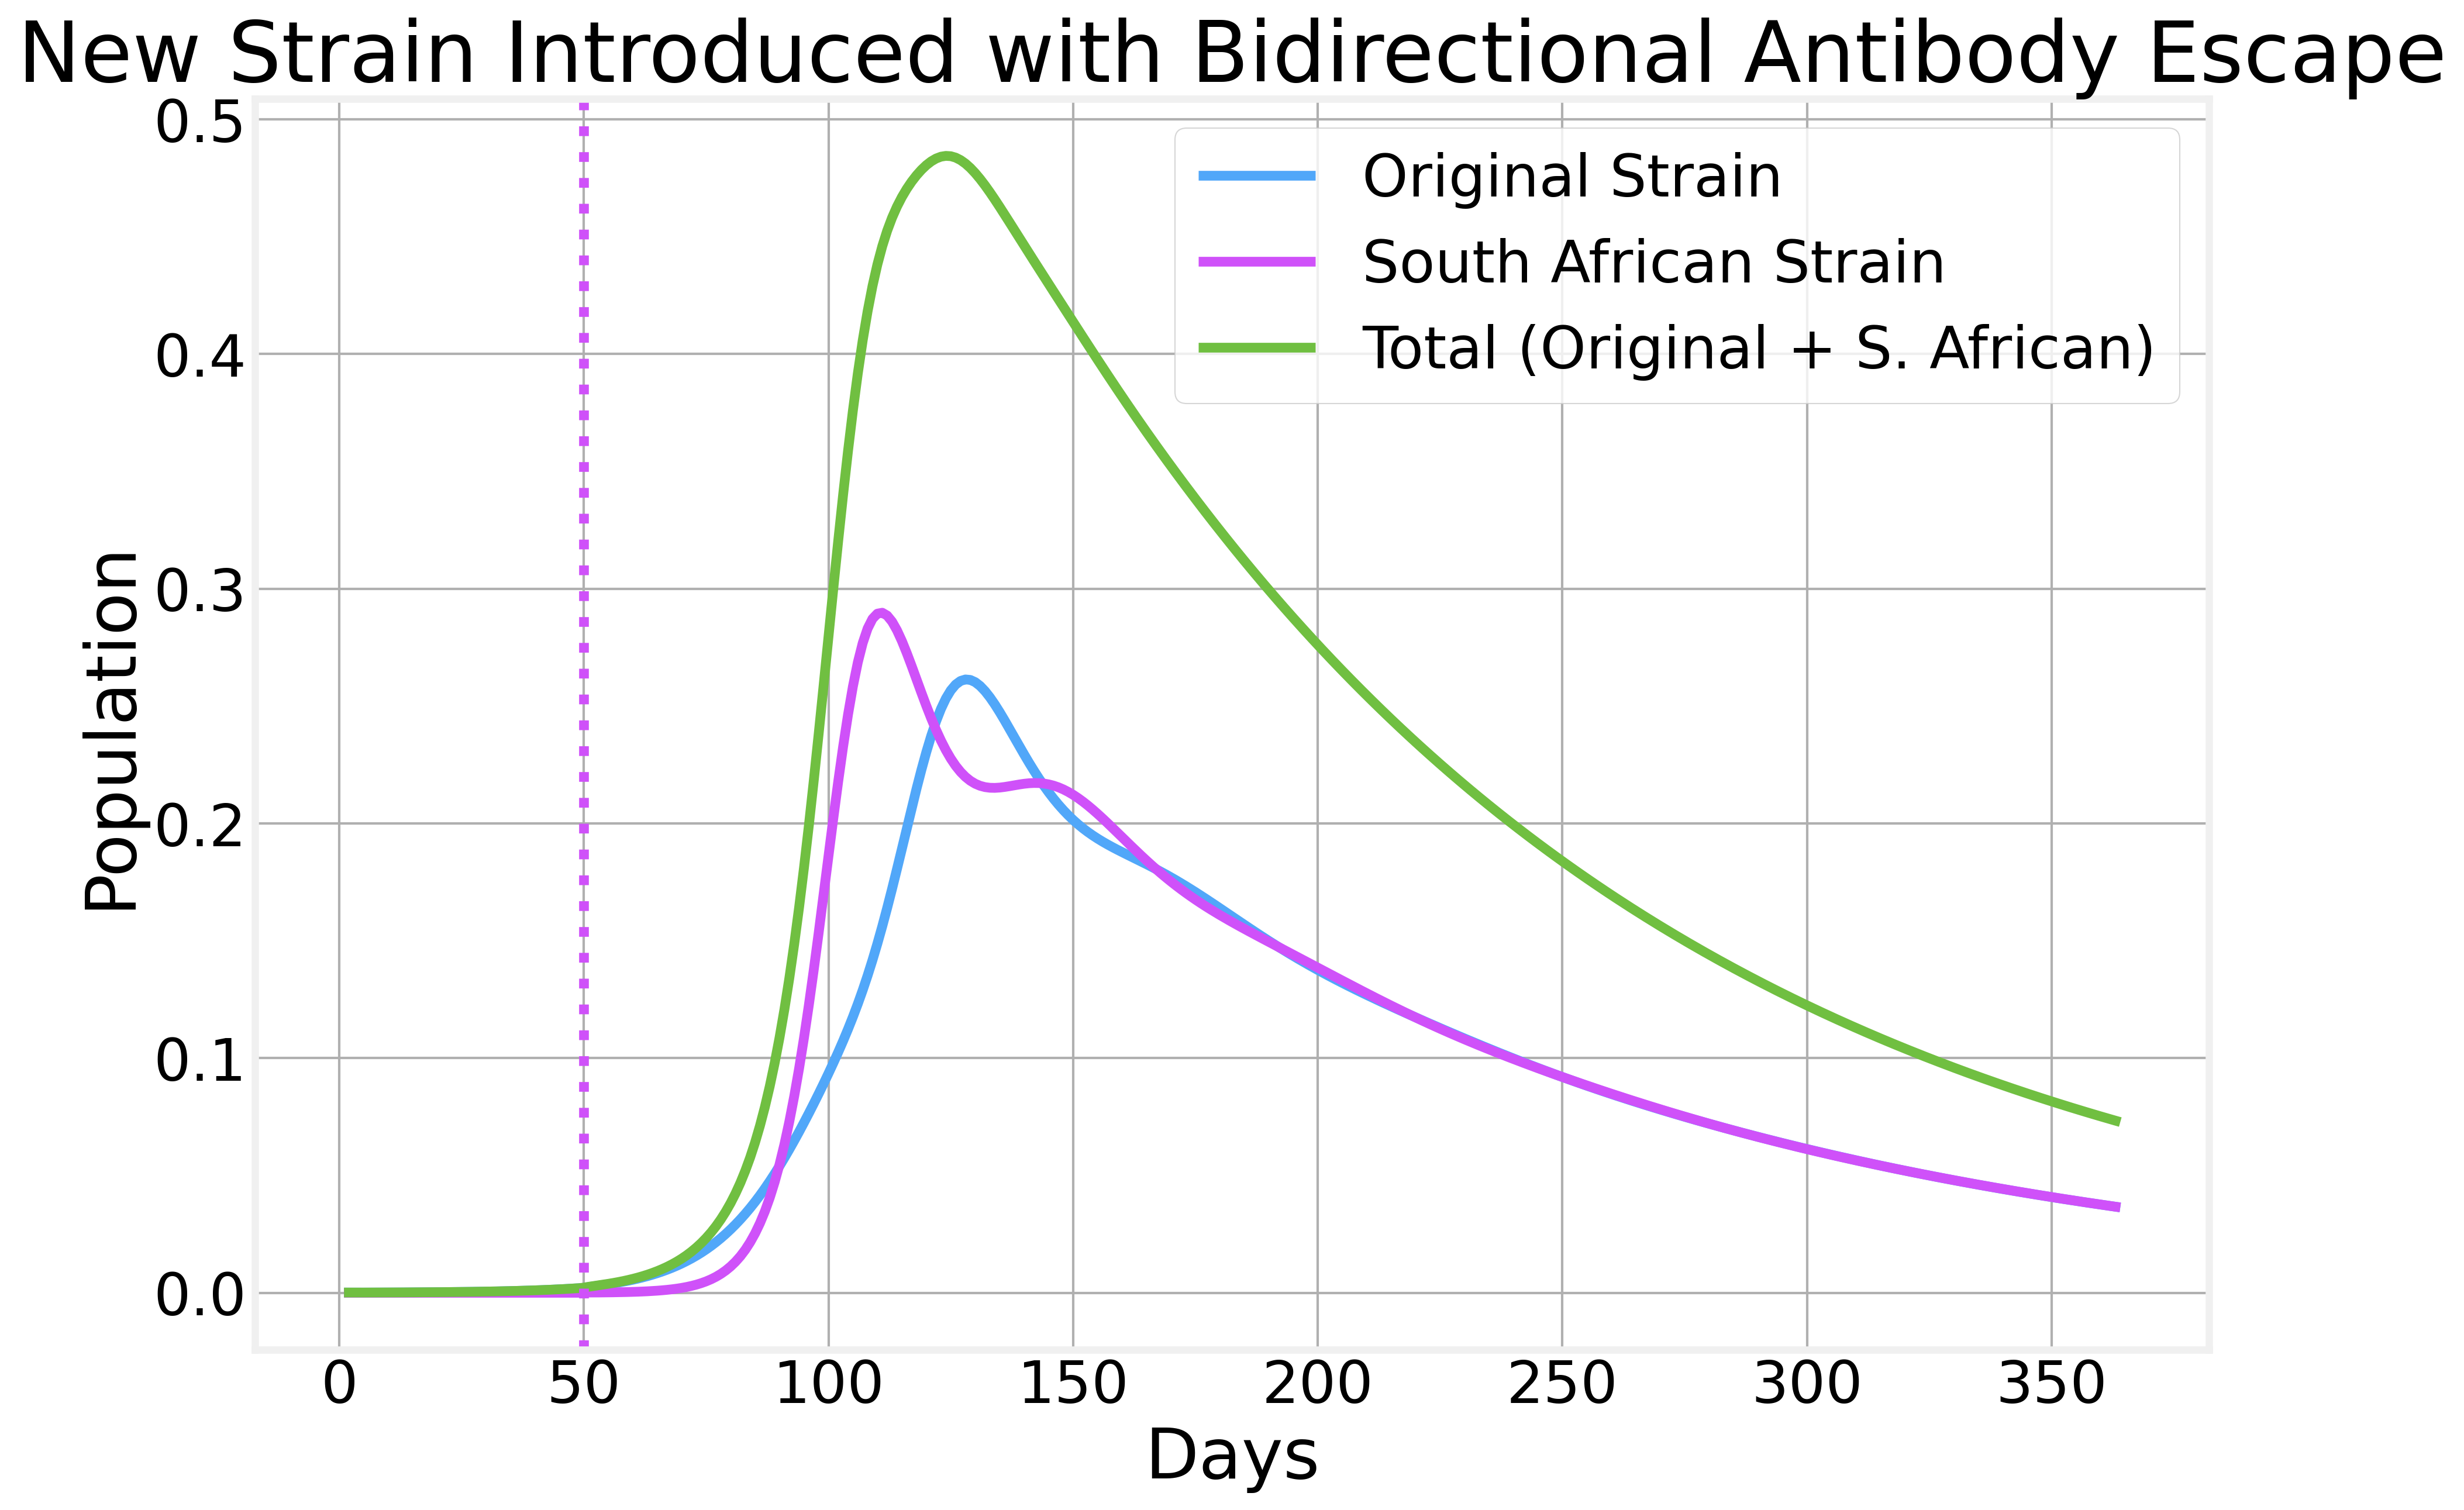

In [70]:
ax = (introduction2.Io/N).plot(label='Original Strain')
((introduction2.In)/N).plot(ax=ax, label='South African Strain')
((introduction2.Io+introduction2.In)/N).plot(ax=ax, label='Total (Original + S. African)')
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Population')
ax.set_title('New Strain Introduced with Bidirectional Antibody Escape')
ax.axvline(x=50, linestyle=':', color=colors[1])

# What is the connection between variants, seroconversion and convergent evolution of similar variant gene subsets?

To what degree does seroconversion create a selective pressure for antibody escape, and how do we model that?

We define convergent evolution as the likelihood that two strains independently mutate to the same molecular phenotype (epidemiological

We assume the UK variant and the Houston variant converge to the same amino acid phenotype.

UK variant has R0 mutation.
South African variant has antibody escape mutation to Pfizer.  